# Imports

In [1]:
import sqlite3
import pandas as pd
import re # for regex functionality
import matplotlib.pyplot as plt # Import for visuals
from matplotlib.ticker import FuncFormatter
import seaborn as sns
# need to import data dictionary python file that I created - 
import sys
import os

# Get the absolute path to the directory
module_path = os.path.abspath('../data/meta data')
# Add the directory to sys.path
sys.path.append(module_path)
# Import the dictionary from the Python file
from vehicle_data_descriptions import descript_dict

# Set display options to prevent wrapping columns
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.width', None)

### Read CSV file to data frame and load into sqlite database.

In [2]:
vehicle_data = pd.read_csv('../data/vehicles.csv', dtype={74: str, 75: str, 77: str}) # make sure these specific columns contain string values as they were mixed value types.

# Create/Connect to SQLite database
connection = sqlite3.connect('../data/vehicles_data.db')
vehicle_data.to_sql('vehicles_data_sql', connection, if_exists='replace', index=False)
connection.close()

### Test read data from sqlite db

In [3]:
connection = sqlite3.connect('../data/vehicles_data.db')
df = pd.read_sql_query('SELECT * FROM vehicles_data_sql', connection)
connection.close()

# print(df.head(2))
# print(df.columns)

- List which columns to keep

In [4]:
keep_columns = ['barrels08', 'charge240', 'cityE', 'co2', 'co2TailpipeGpm', 'comb08', 'combE','cylinders', 'displ', 'drive', 'engId', 'eng_dscr', 'feScore', 'fuelCost08', 'fuelType', 'fuelType1',  'ghgScore', 'id', 
           'make', 'model', 'mpgData', 'range', 'rangeCity', 'rangeHwy', 'trany', 'VClass', 'year', 'youSaveSpend', 'baseModel', 'trans_dscr', 'tCharger', 'sCharger', 'atvType', 'evMotor', 'mfrCode', 
           'c240Dscr', 'charge240b'] # 37 total columns to keep, possible usable data

- List which fuel types to remove

In [5]:
remove_fuel_types = ['Diesel', 'CNG', 'Gasoline or natural gas', 'Gasoline or E85', 'Gasoline or propane' 'Premium or E85', 'Premium Gas or Electricity', 'Regular Gas and Electricity', 
                     'Premium and Electricity', 'Regular Gas or Electricity', 'Hydrogen', 'Gasoline or propane', 'Premium or E85'] # rows where cars use unwanted fuel types


### Clean initial data - by loading only what I need from the sqlite database.

In [6]:
keep_col_str = ', '.join(keep_columns) # creats necessary string to place in the SQL command when loading the data for columns to select
remove_fuel_types_str = ', '.join(f"'{fuel}'" for fuel in remove_fuel_types) # need single quotes for each item, creates string in proper format to 
                                                                             # not select certain fuel types for the dataset

sqlite_query = f"""
SELECT {keep_col_str}
FROM vehicles_data_sql
WHERE fuelType NOT IN ({remove_fuel_types_str})
"""

connection = sqlite3.connect('../data/vehicles_data.db')

loaded_vehicle_data = pd.read_sql_query(sqlite_query, connection)

connection.close()

#loaded_vehicle_data

### Write data to txt file - all unique values for viewing and adjustment.
- This was to allow me to open the data in a txt file and view the data in each column to determine how best to use or to remove it.

In [7]:
# Write to txt file so I can view the data

spacer = ['-'*20, '-'*2]
#titleList = ['Data Discovery', 'Annual fuel consumption', 'Charging time', 'Mileage/Type', 'Carbon Emissions per mile', 'MPG/MPKwh']

# get names and unique values for each column in the column list
with open('../Documents/Column_Descript_Unique_Values.txt', 'w') as file:
    for col in loaded_vehicle_data:
        unique_values = loaded_vehicle_data[col].unique()
        description = descript_dict.get(col, "No description available")
        file.write(f'{col}:  {description}\n')
        file.write(f"{spacer[1]}\n")
        for value in unique_values:
            file.write(f"{value}, ")
        file.write("\n" + "-"*10 + "\n")



### Further cleaning data
- Selected columns to drop - unnecessary columns
- Renamed some columns for better clearity
- Determined that under the base fuel type column if it is regular or premium gas it will appear as na, filled with gasoline as base fuel type for those two
- This leaved three base fuel types, Gasoline, Electricity, Hybrid

- created list of columns to drop - not needed

In [8]:
column_drop_list = ['mfrCode', 'evMotor', 'sCharger', 'tCharger', 'trans_dscr', 'rangeHwy', 'rangeCity', 'mpgData', 
                    'eng_dscr', 'engId', 'cityE', 'co2TailpipeGpm', 'fuelType', 'charge240b']

loaded_vehicle_data = loaded_vehicle_data.drop(columns=column_drop_list)

- Renamed Columns for clarity, Viewed data to determine structure

In [9]:
# rename some columns to provide better context.
loaded_vehicle_data.rename(columns={
    'c240Dscr': 'charger_descript_240', 'charge240': 'charge_hours_240', 'co2': 'co2', 
    'fuelType1': 'fuel_type', 'comb08': 'comb_MPG_MPGe', 'fuelCost08': 'est_ann_fuel_cost',
    'combE': 'comb_kWh_100miles', 'feScore':'epa_FuelEcon_score', 'ghgScore': 'greenhouse_Gas_Score',
    'barrels08': 'est_petro_cons', 'youSaveSpend': '5yr_SaveSpend', 'baseModel': 'base_Model',
    'atvType': 'base_fuel_type'
    }, inplace=True)
# print(loaded_vehicle_data.columns)
# print(loaded_vehicle_data.shape)
# print(loaded_vehicle_data.base_Model)
# print(loaded_vehicle_data.model)
# print(loaded_vehicle_data.make)

# c240Dscr to charger_descript_240, charge240 to charge_hours_240, fuelType1 to fuel_type

- Filled na base fuel types as Gasoline

In [10]:
# print(loaded_vehicle_data[['co2', 'co2TailpipeGpm']])
# print(loaded_vehicle_data['co2'].unique())
# print(loaded_vehicle_data['co2TailpipeGpm'].unique()) - Removed column

# After viewing in Data Wrangler, co2 and co2TailpipeGpm seem to contain the same data but one is rounded and one contains decimals

#loaded_vehicle_data['base_fuel_type'].fillna('Gasoline', inplace=True) # fill na with Gasoline as that is going to be the base fuel if not electric or hybrid

loaded_vehicle_data['base_fuel_type'] = loaded_vehicle_data['base_fuel_type'].fillna('Gasoline') # fill na with Gasoline as that is going to be the base fuel if not electric or hybrid

loaded_vehicle_data['base_fuel_type'].unique()

array(['Gasoline', 'Hybrid', 'EV'], dtype=object)

### load another data set to combine with existing data

In [11]:
vehicle_sales_data = pd.read_csv('../data/car_prices_dataset/car_prices.csv')

# vehicle_sales_data['transmission'].unique()

vehicle_sales_data

#loaded_vehicle_data_ev = loaded_vehicle_data[loaded_vehicle_data['base_fuel_type'] == 'EV']




,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558832,2015,Kia,K900,Luxury,Sedan,NaN,knalw4d4xf6019304,in,45.0,18255.0,silver,black,avis corporation,35300.0,33000.0,Thu Jul 09 2015 07:00:00 GMT-0700 (PDT)
558833,2012,Ram,2500,Power Wagon,Crew Cab,automatic,3c6td5et6cg112407,wa,5.0,54393.0,white,black,i -5 uhlmann rv,30200.0,30800.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT)
558834,2012,BMW,X5,xDrive35d,SUV,automatic,5uxzw0c58cl668465,ca,48.0,50561.0,black,black,financial services remarketing (lease),29800.0,34000.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT)
558835,2015,Nissan,Altima,2.5 S,sedan,automatic,1n4al3ap0fc216050,ga,38.0,16658.0,white,black,enterprise vehicle exchange / tra / rental / tulsa,15100.0,11100.0,Thu Jul 09 2015 06:45:00 GMT-0700 (PDT)


### Create a column that will allow the two data sets to combine
- Creating a key that would not have duplicates and would be identicle between the two tables is unlikley to be possible.
- The solution appears to be to do a 1 to many combination that would allow for further aggregation on the key when necessary for visualization.
- I will be able to clean the sales data and aggregate the data to have only one copy of a key to use, I will need to keep many keys on the loaded_vehicle_data.
- Show the count to see the rows with multiple keys and how many, some have a large number, most of the data regarding sales will be averaged so when using the sales data, I will need to aggregate on that as averages and will not have access to max, min, ect types of data for sales unless I use the original data set.

In [12]:
# Remove spaces and combine the columns into lowercase
loaded_vehicle_data['year_make_model_key'] = (
    loaded_vehicle_data['year'].astype(str).str.replace(r'[^a-zA-Z0-9]', '', regex=True) +
    loaded_vehicle_data['make'].str.replace(r'[^a-zA-Z0-9]', '', regex=True) + 
    loaded_vehicle_data['base_Model'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)
).str.lower()

# print(loaded_vehicle_data.columns)
# print('\n')

# key_counts = loaded_vehicle_data['year_make_model_key'].value_counts()
# print(key_counts[key_counts > 1])  # Display keys that appear more than once



### do the same with the sales data
- verify the key does not have any duplicates.

In [13]:
# print(vehicle_sales_data.columns)

refined_vehicle_sales_data = vehicle_sales_data[['year', 'make', 'model', 'condition', 'odometer', 'sellingprice']]

# print(vehicle_sales_data.columns)

vehicle_sales_data['year_make_model_key'] = (
    vehicle_sales_data['year'].astype(str).str.replace(r'[^a-zA-Z0-9]', '', regex=True) +
    vehicle_sales_data['make'].str.replace(r'[^a-zA-Z0-9]', '', regex=True) + 
    vehicle_sales_data['model'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)
).str.lower()

# Group by 'year_make_model_key' and calculate the required aggregations
processed_sales_data = vehicle_sales_data.groupby('year_make_model_key', as_index=False).agg(
    avg_selling_price=('sellingprice', 'mean'),  # Average selling price
    avg_odometer_reading=('odometer', 'mean'),  # Average odometer reading
    avg_condition=('condition', 'mean'),  # Average odometer reading
    number_of_sales=('year_make_model_key', 'size')       # Count occurrences, reflects number of sales of that specific year make model
)

# print(processed_sales_data)

# key_counts_2 = processed_sales_data['year_make_model_key'].value_counts()
# print(key_counts_2[key_counts_2 > 1])  # Display keys that appear more than once


- Verify the amount and quality of data that will merge successfully between the two tables.  

In [14]:
filtered_df = loaded_vehicle_data[loaded_vehicle_data['year_make_model_key'].isin(processed_data['year_make_model_key'])]

print(filtered_df.shape)
filtered_df

NameError: name 'processed_data' is not defined

### Join the tables and view the rows that do not match to see what issues may exist with the created key
- Use a many to one ratio since the sales data is all averaged so it should allow for averages in correlation with fuel economy data to be used with no real issues

In [16]:
# Perform a full outer join on the 'make_model_key' column
combined_sales_fueleconomy_data = pd.merge(
    loaded_vehicle_data,
    processed_sales_data,
    on='year_make_model_key',
    how='left'  # Retains all rows from loaded_vehicle_data
)


combined_sales_fueleconomy_data

# vehicle_data_ev = combined_sales_fueleconomy_data[combined_sales_fueleconomy_data['base_fuel_type'] == 'EV']

# vehicle_data_ev

# ev = combined_sales_fueleconomy_data[combined_sales_fueleconomy_data['base_fuel_type'] == 'EV']
# combined_sales_fueleconomy_data
# print(merged_data['base_fuel_type'].unique())

,est_petro_cons,charge_hours_240,co2,comb_MPG_MPGe,comb_kWh_100miles,cylinders,displ,drive,epa_FuelEcon_score,est_ann_fuel_cost,...,year,5yr_SaveSpend,base_Model,base_fuel_type,charger_descript_240,year_make_model_key,avg_selling_price,avg_odometer_reading,avg_condition,number_of_sales
0,14.167143,0.0,-1,21,0.0,4.0,2.0,Rear-Wheel Drive,-1,2200,...,1985,-2750,Spider,Gasoline,None,1985alfaromeospider,NaN,NaN,NaN,NaN
1,27.046364,0.0,-1,11,0.0,12.0,4.9,Rear-Wheel Drive,-1,4250,...,1985,-13000,Testarossa,Gasoline,None,1985ferraritestarossa,NaN,NaN,NaN,NaN
2,11.018889,0.0,-1,27,0.0,4.0,2.2,Front-Wheel Drive,-1,1750,...,1985,-500,Charger,Gasoline,None,1985dodgecharger,NaN,NaN,NaN,NaN
3,27.046364,0.0,-1,11,0.0,8.0,5.2,Rear-Wheel Drive,-1,4250,...,1985,-13000,B150/B250 Wagon,Gasoline,None,1985dodgeb150b250wagon,NaN,NaN,NaN,NaN
4,15.658421,0.0,-1,19,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,-1,3150,...,1993,-7500,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45037,13.523182,0.0,-1,22,0.0,4.0,2.2,Front-Wheel Drive,-1,2100,...,1993,-2250,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN
45038,12.935217,0.0,-1,23,0.0,4.0,2.2,Front-Wheel Drive,-1,2050,...,1993,-2000,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN
45039,14.167143,0.0,-1,21,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,-1,2200,...,1993,-2750,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN
45040,14.167143,0.0,-1,21,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,-1,2200,...,1993,-2750,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN


### Construct additional columns to compare.
- fuel cost per mile column


In [17]:
# combined_sales_fueleconomy_data

# Cost calculation to make a round trip to work every day, estimating it takes 20 miles to and from work
def calculate_dollars_to_work(row):
    if row['base_fuel_type'] in ['Gasoline', 'Hybrid']:
        return round((2.50 / row['comb_MPG_MPGe']) * 20, 2)  # Round gasoline/hybrid calculation
    elif row['base_fuel_type'] == 'EV':
        kWh_per_mile = row['comb_kWh_100miles'] / 100  # kWh needed for 1 mile
        return round((kWh_per_mile * 0.13) * 20, 2)  # Multiply by the cost per kWh (13 cents) round to nearest 5 decimals
    else:
        return None  # Handle unexpected fuel types

# Apply the calculation to create the new column
combined_sales_fueleconomy_data['dollars_to_work'] = combined_sales_fueleconomy_data.apply(calculate_dollars_to_work, axis=1)

combined_sales_fueleconomy_data

,est_petro_cons,charge_hours_240,co2,comb_MPG_MPGe,comb_kWh_100miles,cylinders,displ,drive,epa_FuelEcon_score,est_ann_fuel_cost,...,5yr_SaveSpend,base_Model,base_fuel_type,charger_descript_240,year_make_model_key,avg_selling_price,avg_odometer_reading,avg_condition,number_of_sales,dollars_to_work
0,14.167143,0.0,-1,21,0.0,4.0,2.0,Rear-Wheel Drive,-1,2200,...,-2750,Spider,Gasoline,None,1985alfaromeospider,NaN,NaN,NaN,NaN,2.38
1,27.046364,0.0,-1,11,0.0,12.0,4.9,Rear-Wheel Drive,-1,4250,...,-13000,Testarossa,Gasoline,None,1985ferraritestarossa,NaN,NaN,NaN,NaN,4.55
2,11.018889,0.0,-1,27,0.0,4.0,2.2,Front-Wheel Drive,-1,1750,...,-500,Charger,Gasoline,None,1985dodgecharger,NaN,NaN,NaN,NaN,1.85
3,27.046364,0.0,-1,11,0.0,8.0,5.2,Rear-Wheel Drive,-1,4250,...,-13000,B150/B250 Wagon,Gasoline,None,1985dodgeb150b250wagon,NaN,NaN,NaN,NaN,4.55
4,15.658421,0.0,-1,19,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,-1,3150,...,-7500,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN,2.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45037,13.523182,0.0,-1,22,0.0,4.0,2.2,Front-Wheel Drive,-1,2100,...,-2250,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN,2.27
45038,12.935217,0.0,-1,23,0.0,4.0,2.2,Front-Wheel Drive,-1,2050,...,-2000,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN,2.17
45039,14.167143,0.0,-1,21,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,-1,2200,...,-2750,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN,2.38
45040,14.167143,0.0,-1,21,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,-1,2200,...,-2750,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN,2.38


- CO2 created during a round trip to work, if gasoline from burning fuel, if electric from coal powered plant to create the power.  Although this will not be accurate as much of our electricity is produced from other sources such as Wolf Creek Dam.

In [18]:
def calculate_co2_to_work(row):
    if row['base_fuel_type'] in ['Gasoline', 'Hybrid']:
        if row['co2'] == -1:  # Check for unavailable CO2 data
            return None
        else:
            co2_per_mile_grams = row['co2']  # CO2 in grams per mile
            co2_per_mile_pounds = co2_per_mile_grams / 453.592  # Convert grams to pounds
            return co2_per_mile_pounds * 20  # CO2 for 20 miles (round trip)
    elif row['base_fuel_type'] == 'EV':
        kWh_per_mile = row['comb_kWh_100miles'] / 100  # kWh needed for 1 mile
        co2_per_mile_pounds = kWh_per_mile * 2.2  # CO2 in pounds per kWh
        return co2_per_mile_pounds * 20  # CO2 for 20 miles (round trip)
    else:
        return None  # Handle unexpected fuel types

# Apply the calculation to create the new column
combined_sales_fueleconomy_data['co2_to_work'] = combined_sales_fueleconomy_data.apply(calculate_co2_to_work, axis=1)

combined_sales_fueleconomy_data

,est_petro_cons,charge_hours_240,co2,comb_MPG_MPGe,comb_kWh_100miles,cylinders,displ,drive,epa_FuelEcon_score,est_ann_fuel_cost,...,base_Model,base_fuel_type,charger_descript_240,year_make_model_key,avg_selling_price,avg_odometer_reading,avg_condition,number_of_sales,dollars_to_work,co2_to_work
0,14.167143,0.0,-1,21,0.0,4.0,2.0,Rear-Wheel Drive,-1,2200,...,Spider,Gasoline,None,1985alfaromeospider,NaN,NaN,NaN,NaN,2.38,NaN
1,27.046364,0.0,-1,11,0.0,12.0,4.9,Rear-Wheel Drive,-1,4250,...,Testarossa,Gasoline,None,1985ferraritestarossa,NaN,NaN,NaN,NaN,4.55,NaN
2,11.018889,0.0,-1,27,0.0,4.0,2.2,Front-Wheel Drive,-1,1750,...,Charger,Gasoline,None,1985dodgecharger,NaN,NaN,NaN,NaN,1.85,NaN
3,27.046364,0.0,-1,11,0.0,8.0,5.2,Rear-Wheel Drive,-1,4250,...,B150/B250 Wagon,Gasoline,None,1985dodgeb150b250wagon,NaN,NaN,NaN,NaN,4.55,NaN
4,15.658421,0.0,-1,19,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,-1,3150,...,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN,2.63,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45037,13.523182,0.0,-1,22,0.0,4.0,2.2,Front-Wheel Drive,-1,2100,...,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN,2.27,NaN
45038,12.935217,0.0,-1,23,0.0,4.0,2.2,Front-Wheel Drive,-1,2050,...,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN,2.17,NaN
45039,14.167143,0.0,-1,21,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,-1,2200,...,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN,2.38,NaN
45040,14.167143,0.0,-1,21,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,-1,2200,...,Legacy/Outback,Gasoline,None,1993subarulegacyoutback,NaN,NaN,NaN,NaN,2.38,NaN


### Bar Chart: Fuel Efficiency Over Time (Gasoline Vehicles)
- I have data for vehicles over the years so I figured why not have a look and see how the fuel efficiency has changed.

- look at data to decide what to select for display in the first table.  commented out after looking at to clean up book.

In [ ]:
# print(combined_sales_fueleconomy_data['year'].dtype)

# print(combined_sales_fueleconomy_data['comb_MPG_MPGe'].describe())

# print(combined_sales_fueleconomy_data['VClass'].unique())

# print(combined_sales_fueleconomy_data['VClass'].value_counts())


- Setting up a Line Graph using Seaborn with selected VClass over the years to view how fuel efficiency has been effected by time.
    - First filter the data to only include Gasoline fueled vehicles.
    - Next list what VClass I wish to view, as ther is a large number of them and Selecting the most important makes the data easier to view.
    - Filter the data based on the selected VClass.
    - Make sure to drop any null values.
    - To make the data easier to read filter for every 2 years.
    - Setup line plot and show it.

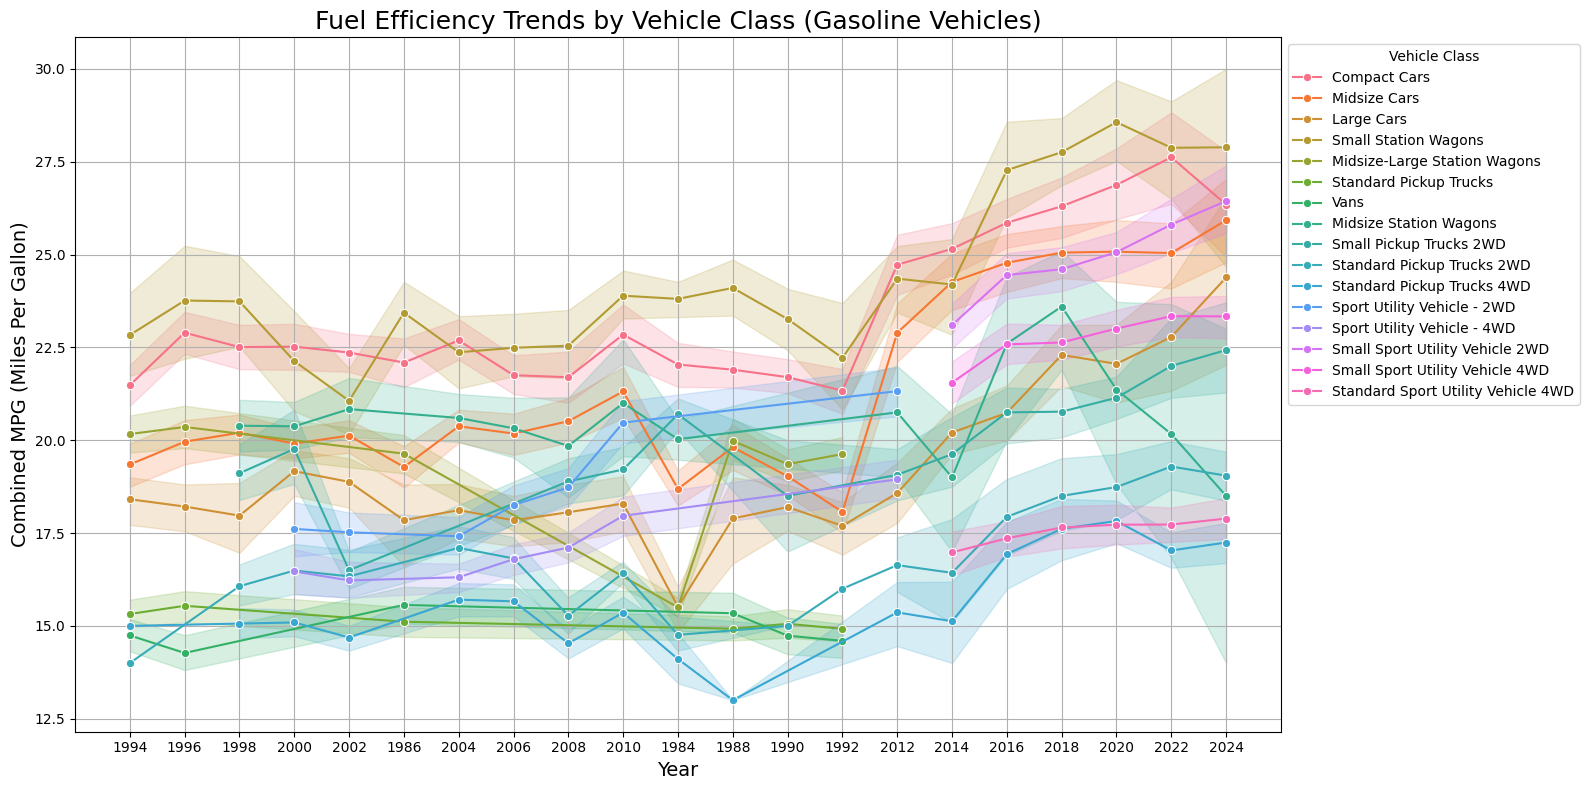

In [19]:
# Example: Filter gasoline vehicles
gasoline_df = combined_sales_fueleconomy_data[combined_sales_fueleconomy_data['base_fuel_type'] == 'Gasoline']

# List of selected VClass types
selected_vclass = [
    "Compact Cars",
    "Midsize Cars",
    "Large Cars",
    "Standard Pickup Trucks",
    "Sport Utility Vehicle - 4WD",
    "Small Sport Utility Vehicle 4WD",
    "Small Station Wagons",
    "Sport Utility Vehicle - 2WD",
    "Standard Sport Utility Vehicle 4WD",
    "Standard Pickup Trucks 4WD",
    "Standard Pickup Trucks 2WD",
    "Vans",
    "Small Sport Utility Vehicle 2WD",
    "Midsize-Large Station Wagons",
    "Midsize Station Wagons",
    "Small Pickup Trucks 2WD"
]

# Filter the DataFrame for the selected classes
gasoline_df = gasoline_df[gasoline_df['VClass'].isin(selected_vclass)]

# Check that the data contains no NaN values for relevant columns
gasoline_df = gasoline_df.dropna(subset=['year', 'VClass', 'comb_MPG_MPGe'])

# Filter for 10-year increments
gasoline_df = gasoline_df[gasoline_df['year'].astype(int) % 2 == 0]

# Convert year to categorical if needed and ensure it's sorted
gasoline_df['year'] = gasoline_df['year'].astype(str)

# Line plot for fuel efficiency trends
plt.figure(figsize=(16, 8))
sns.lineplot(x="year", y="comb_MPG_MPGe", hue="VClass", data=gasoline_df, marker="o")

# Add titles and labels
plt.title("Fuel Efficiency Trends by Vehicle Class (Gasoline Vehicles)", fontsize=18)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Combined MPG (Miles Per Gallon)", fontsize=14)
plt.legend(title="Vehicle Class", loc="upper left", bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.grid(True)
plt.tight_layout()
plt.show()

- Final thoughts after viewing the line graph.  
    - As a quick reference, it looks like on average fuel efficiency has improved over time.
    - Only two vehicle classed were able to get over 20 MPG in the 80s, now several vehicle classes have broken 20 MPG

### Gasoline Vs. Electric

- In this cell we compare how much it costs to drive round trip estimated at current energy prices and 20 miles to work and home.  Based on Vehicle Class.
    - Filter for vehicles that have both EV and Gasoline fuel types.
    - Further filter the dataframe for desired VClasses.  This is to make the chart much more readable.
    - Shorten the names of the vehicles to increase readability.
    - Prepare and display the chart.

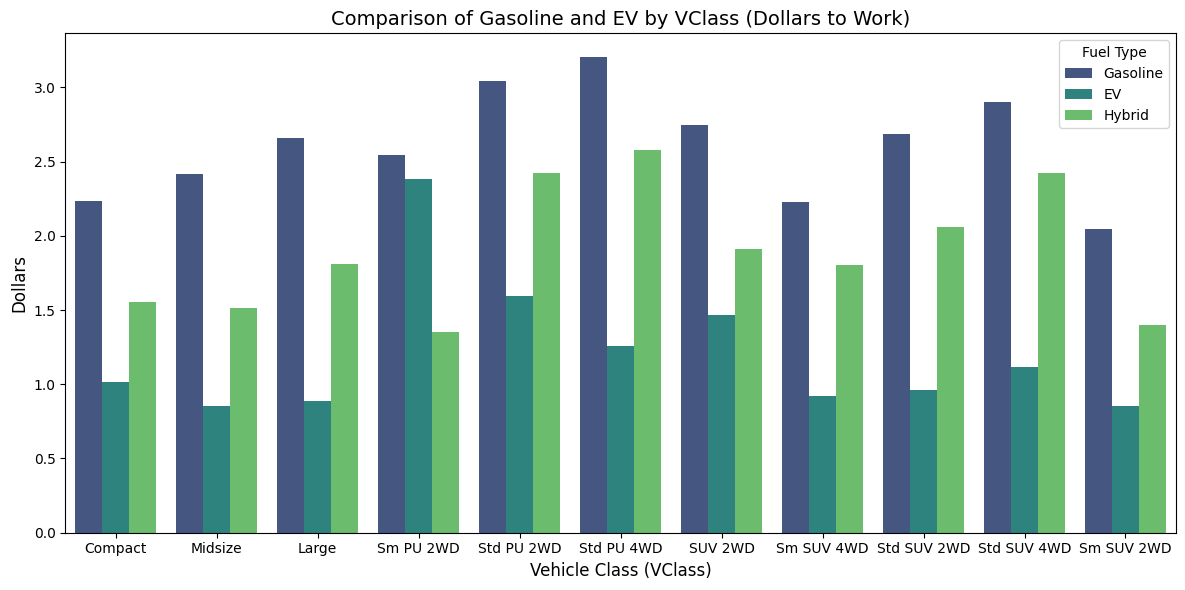

In [20]:
# Initialize an empty list to store VClass values
vclass_with_both = []

# Loop through the unique VClass values
for vclass in combined_sales_fueleconomy_data['VClass'].unique():
    # Filter the data for the current VClass
    fuel_types = combined_sales_fueleconomy_data[combined_sales_fueleconomy_data['VClass'] == vclass]['base_fuel_type'].unique()
    
    # Check if both 'gasoline' and 'electric' are in the fuel types
    if 'Gasoline' in fuel_types and 'EV' in fuel_types:
        vclass_with_both.append(vclass)

# Print the list of VClass values
# print(vclass_with_both)

# Filter the DataFrame for the selected classes
filtered_df = combined_sales_fueleconomy_data[combined_sales_fueleconomy_data['VClass'].isin(vclass_with_both)]

#----------  Use this to see the most popular vehicles that have both EV and Gasoline
# # Step 1: Count the occurrences of each VClass in the filtered list
# popular_vclass_counts = filtered_df[filtered_df['VClass'].isin(vclass_with_both)].groupby('VClass').size()

# # Step 2: Get the top 5 most popular VClass types
# top_vclass = popular_vclass_counts.nlargest(20).index.tolist()

# # Step 3: Filter the DataFrame for only these top 5 VClass types
# df_top_vclass = filtered_df[filtered_df['VClass'].isin(top_vclass)]

# # Step 4: Validate the filtered data
# print(df_top_vclass['VClass'].unique())  # Check included VClass types
# print(df_top_vclass.shape)  # Validate the number of rows
#------------

further_filter = ['Compact Cars', 'Midsize Cars', 'Large Cars', 'Small Pickup Trucks 2WD', 
 'Standard Pickup Trucks 2WD', 'Standard Pickup Trucks 4WD', 
 'Sport Utility Vehicle - 2WD', 'Small Sport Utility Vehicle 4WD', 
 'Standard Sport Utility Vehicle 2WD', 'Standard Sport Utility Vehicle 4WD', 
 'Small Sport Utility Vehicle 2WD']

refined_df = filtered_df[filtered_df['VClass'].isin(further_filter)]

# Define a mapping of long names to short, unique identifiers
vclass_short_names = {
    "Compact Cars": "Compact",
    "Midsize Cars": "Midsize",
    "Large Cars": "Large",
    "Small Pickup Trucks 2WD": "Sm PU 2WD",
    "Standard Pickup Trucks 2WD": "Std PU 2WD",
    "Standard Pickup Trucks 4WD": "Std PU 4WD",
    "Sport Utility Vehicle - 2WD": "SUV 2WD",
    "Small Sport Utility Vehicle 4WD": "Sm SUV 4WD",
    "Standard Sport Utility Vehicle 2WD": "Std SUV 2WD",
    "Standard Sport Utility Vehicle 4WD": "Std SUV 4WD",
    "Small Sport Utility Vehicle 2WD": "Sm SUV 2WD"
}

# Apply the mapping to rename VClass in the DataFrame - this should allow them to be viewed better in the graph
refined_df.loc[:, 'VClass'] = refined_df['VClass'].replace(vclass_short_names)

# Validate the updated VClass column
# print(refined_df['VClass'].unique())  # Check the short identifiers

# Melt the data for easier plotting
melted_df = refined_df.melt(id_vars=["VClass", "base_fuel_type"], 
                    value_vars=["dollars_to_work"], # "dollars_to_work", "co2_to_work"
                    var_name="Metric", value_name="Value")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="VClass", y="Value", hue="base_fuel_type", palette="viridis", data=melted_df, errorbar=None)
plt.title('Comparison of Gasoline and EV by VClass (Dollars to Work)', fontsize=14) # (CO2 and Dollars to Work)
plt.xlabel('Vehicle Class (VClass)', fontsize=12)
plt.ylabel('Dollars', fontsize=12)
plt.legend(title='Fuel Type')
plt.tight_layout()
plt.show()

- After thoughts
    - It is significantly cheaper to drive an electric vehicle to work
    - Gasoline is the most expensive fuel to use.
    - Using a hybrid reduces your gasoline cost by approximately 1/3.
    - Electric will cost you 1/3 as much to drive to work and home on average and is typically under 1 dollar.

- In this graph we are comparing how clean it is to drive an electric vehicle
    - One major caveate - it is using only coal to create the electricity for the vehicles and is omitting any power produced by clean sources such as Wolf Creek Dam.
    - Kept the VClasses that we previously compared, then changed from dollars to co2.

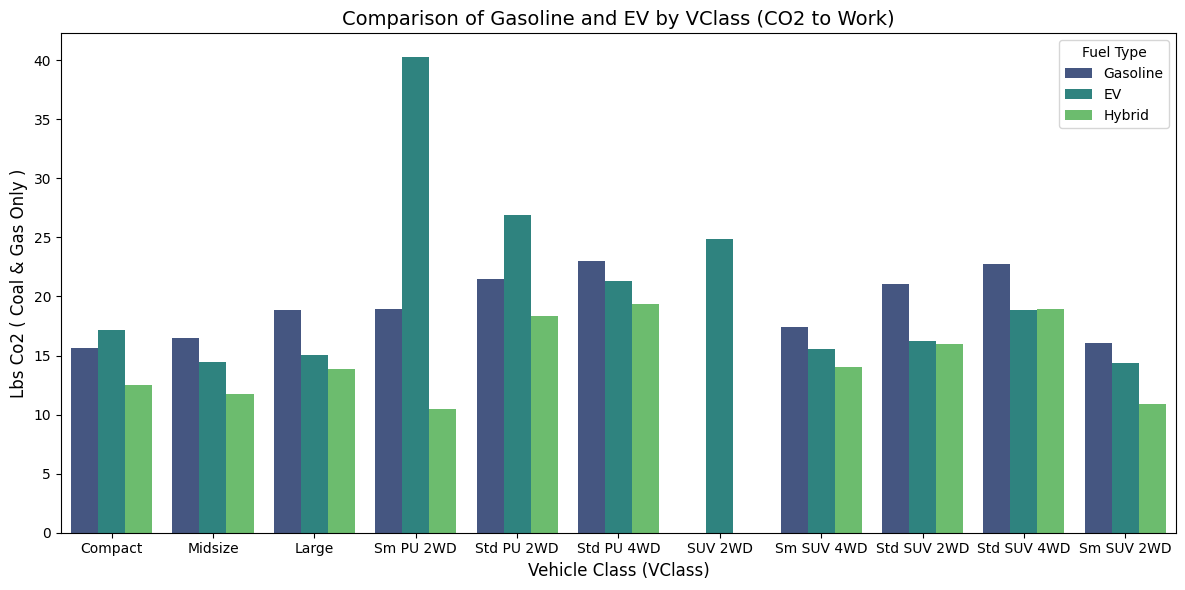

In [21]:
melted_df_2 = refined_df.melt(id_vars=["VClass", "base_fuel_type"], 
                    value_vars=["co2_to_work"], # "dollars_to_work", 
                    var_name="Metric", value_name="Value")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="VClass", y="Value", hue="base_fuel_type", palette="viridis", data=melted_df_2, errorbar=None)
plt.title('Comparison of Gasoline and EV by VClass (CO2 to Work)', fontsize=14) # (CO2 and Dollars to Work)
plt.xlabel('Vehicle Class (VClass)', fontsize=12)
plt.ylabel('Lbs Co2 ( Coal & Gas Only )', fontsize=12)
plt.legend(title='Fuel Type')
plt.tight_layout()
plt.show()

- After thoughts
    - After looking over the data, IF the electricity used to charge an EV was produced with ONLY coal, then the EV would only be sleightly cleaner to drive.
    - With the exception of a few EVs on average it appears that EVs produce 1-3 lbs less Co2 to travel 20 miles than a gasoline engine would produce traveling the same distance.
    - There are three odd cases where the EVs are producing more Co2. 
    - This is ignoring the fact that much of the electricity locally is produced by hydroelectricity which would reduce the over all Co2 rating for EVs

### Comparing Sales Values Between EV, Gasoline and Hybrid Cars.

- filter out VClass based on limited fuel types, filter more popular VClasses, give shortnames for graph.
- group by key and take only one value that is the max value, although they should all be the same if there are duplicates.
- Remove VClasses that only have one fueltype with a selling price.

In [43]:
# print(combined_sales_fueleconomy_data)

# Identify VClasses that have all three base_fuel_types
valid_vclasses = combined_sales_fueleconomy_data.groupby('VClass')['base_fuel_type'].nunique()
valid_vclasses = valid_vclasses[valid_vclasses == 3].index

# Filter the dataset for these valid VClasses
selected_vclass_df = combined_sales_fueleconomy_data[combined_sales_fueleconomy_data['VClass'].isin(valid_vclasses)]

further_filter = ['Compact Cars', 'Midsize Cars', 'Large Cars', 
 'Sport Utility Vehicle - 2WD', 'Small Sport Utility Vehicle 4WD', 
 'Standard Sport Utility Vehicle 2WD', 'Standard Sport Utility Vehicle 4WD', 
 'Small Sport Utility Vehicle 2WD']

ref_selected_vclass_df = selected_vclass_df[selected_vclass_df['VClass'].isin(further_filter)]

# Define a mapping of long names to short, unique identifiers
vclass_short_names = {
    "Compact Cars": "Compact",
    "Midsize Cars": "Midsize",
    "Large Cars": "Large",
    "Small Pickup Trucks 2WD": "Sm PU 2WD",
    "Standard Pickup Trucks 2WD": "Std PU 2WD",
    "Standard Pickup Trucks 4WD": "Std PU 4WD",
    "Sport Utility Vehicle - 2WD": "SUV 2WD",
    "Small Sport Utility Vehicle 4WD": "Sm SUV 4WD",
    "Standard Sport Utility Vehicle 2WD": "Std SUV 2WD",
    "Standard Sport Utility Vehicle 4WD": "Std SUV 4WD",
    "Small Sport Utility Vehicle 2WD": "Sm SUV 2WD"
}

# Apply the mapping to rename VClass in the DataFrame - this should allow them to be viewed better in the graph
ref_selected_vclass_df.loc[:, 'VClass'] = ref_selected_vclass_df['VClass'].replace(vclass_short_names)
# ref_selected_vclass_df

# Group by year_make_model_key and calculate the mean selling price
unique_df = ref_selected_vclass_df.groupby('year_make_model_key', as_index=False).agg({
    'avg_selling_price': 'max',  
    'base_fuel_type': 'first',
    'VClass': 'first'
})

# Group by base_fuel_type and VClass to calculate the mean
aggregated_df = unique_df.groupby(['base_fuel_type', 'VClass'], as_index=False)['avg_selling_price'].mean()

# aggregated_df

# # Identify VClasses with missing avg_selling_price
# vclasses_with_nan = aggregated_df[aggregated_df['avg_selling_price'].isna()]['VClass'].unique()

# # vclasses_with_nan

# # Remove these VClasses from the dataset
# ref_aggregated_df = aggregated_df[~aggregated_df['VClass'].isin(vclasses_with_nan)]
# ref_aggregated_df

- create seaborn bar chart to show a comparison of selling prices between VClass and Fuel Types.

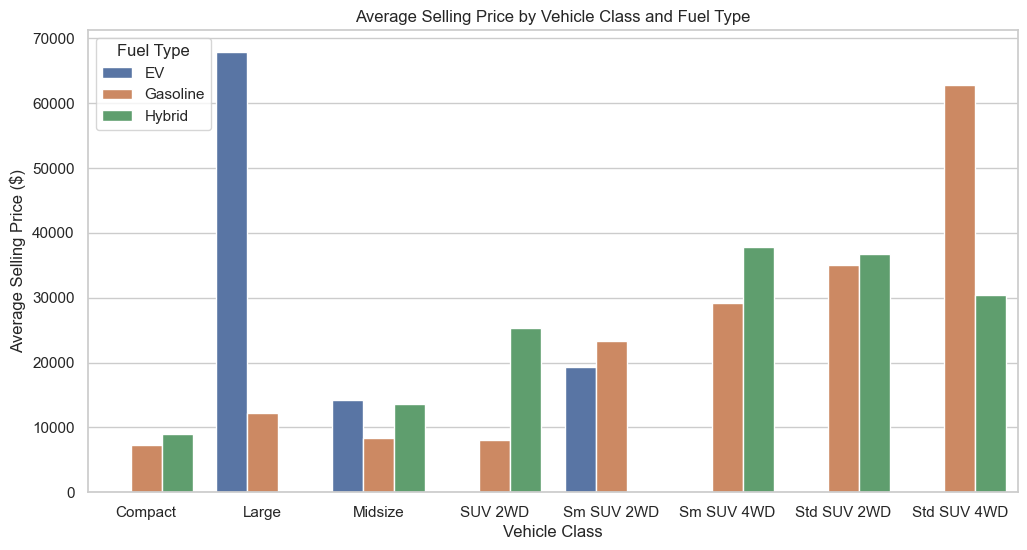

In [44]:
# Set seaborn style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=aggregated_df, x='VClass', y='avg_selling_price', hue='base_fuel_type')
plt.title('Average Selling Price by Vehicle Class and Fuel Type')
plt.xlabel('Vehicle Class')
plt.ylabel('Average Selling Price ($)')
plt.legend(title='Fuel Type')
plt.show()

- After thoughts
    - More complete Sales data would have been nice.
    - Given the limited sales data available it shows that EVs are a small portion of the market.
    - Hybrids seem to be doing well, although they on average run more expensive than Gasoline Engines.
    - The cost of EVs is highly dependant on the Vehicle Class.  Typically comparable to Gasoline however they can be extremely expensive.
    - Gasoline and Hybrids still hold a larger share of the market compared to EVs.